In [1]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, SeabornFig2Grid
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/evlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [2]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

# Training separate α/β classifiers

In [3]:
desc_for_projects_beta = pd.read_csv('data/desc_fmba_new_split_beta.csv').drop(columns=['Unnamed: 0'])[['run', 'folder']]
desc_for_projects_beta

,run,folder
0,050002290808_S117_L002,#2
1,050002630808_S113_L002,#2
2,050003120808_S112_L002,#2
3,050003130808_S114_L002,#2
4,050003450808_S118_L002,#2
...,...,...
1220,p18_72_DNA_S88_L002,#9
1221,p18_73_DNA_S89_L002,#9
1222,p18_74_DNA_S90_L002,#9
1223,p18_75_DNA_S91_L002,#9


In [4]:
desc_for_projects_alpha = pd.read_csv('data/desc_fmba_new_split_alpha.csv').drop(columns=['Unnamed: 0'])[['run', 'folder']]
desc_for_projects_alpha

,run,folder
0,050002290808_S117_L002,#2
1,050002630808_S113_L002,#2
2,050003120808_S112_L002,#2
3,050003130808_S114_L002,#2
4,050003450808_S118_L002,#2
...,...,...
1269,p18_73_DNA_S89_L002,#9
1270,p18_74_DNA_S90_L002,#9
1271,p18_75_DNA_S91_L002,#9
1272,p18_76_DNA_S92_L002,#9


In [5]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_new_split_beta.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)

In [6]:
data_beta

,CASAPGGSYEQYF,CASGLSGGNQPQHF,CASGQGGYEQYF,CASIPGGSYEQYF,CASKLGTSYEQYF,CASKLSGGNQPQHF,CASKPGGSYEQYF,CASLPGGSYEQYF,CASNPGGSYEQYF,CASRASYEQYF,...,DRB1*15,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16,covid,is_test_run
0,-0.382121,-0.313996,-0.506584,-0.379799,-0.295796,-0.289132,-0.397748,-0.365028,-0.394299,0.713687,...,False,True,False,False,False,False,False,False,1,False
1,-0.382121,-0.313996,1.481454,-0.379799,-0.295796,-0.289132,-0.397748,-0.365028,-0.394299,-0.641537,...,False,True,False,False,False,False,False,False,1,False
2,1.972695,-0.313996,-0.506584,1.975921,-0.295796,-0.289132,1.936857,2.141545,3.437178,0.559263,...,False,False,False,False,False,False,False,False,1,False
3,-0.382121,-0.313996,-0.506584,-0.379799,-0.295796,-0.289132,-0.397748,-0.365028,-0.394299,-0.641537,...,True,False,True,False,False,False,False,False,1,False
4,-0.382121,-0.313996,-0.506584,-0.379799,-0.295796,-0.289132,-0.397748,-0.365028,-0.394299,0.677245,...,False,False,False,False,False,False,False,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,1.356324,0.473925,-0.506584,0.489757,-0.295796,-0.289132,0.464014,0.560212,0.312849,-0.641537,...,False,False,False,False,False,False,False,False,1,False
1221,-0.382121,0.112154,-0.506584,-0.379799,-0.295796,0.204772,-0.397748,-0.365028,-0.394299,0.317387,...,False,False,False,False,False,False,False,False,1,False
1222,0.260321,-0.313996,0.940353,0.262890,-0.295796,-0.289132,0.876109,0.318817,0.651007,0.341273,...,False,False,False,False,False,False,False,False,1,False
1223,-0.382121,-0.313996,0.453320,-0.379799,0.035595,-0.289132,-0.397748,-0.365028,-0.186261,0.140863,...,False,False,False,False,False,False,False,False,1,False


In [7]:
X_train, y_train, X_test, y_test = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.77

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 100, 'model__random_state': 42}
Test f1-score for the best model 0.73

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Test f1-score for the best model 0.70

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 4

In [8]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_new_split_alpha.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',)
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data(data=data_alpha, y_column='covid', by='is_test_run')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.73

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.74

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.70

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 8, 'model__n_estimators': 200, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.71

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state':

# Training joint αβ classifier

In [9]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_new_split_joint.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     make_all_features_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid')
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_new_split_joint.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid')
data_joint = pd.concat([data_beta_for_joint[[x for x in data_beta_for_joint.columns if x.startswith('CAS')]], data_alpha_for_joint], axis=1)


X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data(data=data_joint, y_column='covid')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

alpha ready
Started evaluating svm
Best params for svm: {'model__C': 50, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.78

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.76

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.65

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 8, 'model__n_estimators': 75, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.71

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random

# Training classifiers based on metaclones

In [10]:
data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_new_split_beta.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRB_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'folder', 'run'])

data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_new_split_alpha.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRA_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=False,
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     metadata_columns=['is_test_run', 'folder', 'run'])
data_alpha_meta

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16,covid,is_test_run,folder,run
0,-0.698914,-0.712879,-0.707034,-0.579735,-0.474557,-0.177511,-0.010007,-0.677918,2.645309,0.782534,...,False,False,False,False,False,False,1,False,#2,050002290808_S117_L002
1,-0.698914,-0.712879,-0.707034,-0.579735,1.060203,5.281411,1.753486,-0.677918,-0.319670,-0.935883,...,False,False,False,False,False,False,1,False,#2,050002630808_S113_L002
2,-0.698914,-0.710197,-0.707034,-0.579735,-0.272895,-0.177511,0.041841,-0.677918,-0.319670,0.931003,...,False,False,False,False,False,False,1,False,#2,050003120808_S112_L002
3,-0.698914,-0.712879,-0.707034,-0.579735,0.184020,-0.177511,0.785781,-0.659708,-0.319670,0.920116,...,True,False,False,False,False,False,1,False,#2,050003130808_S114_L002
4,-0.698914,-0.712879,-0.707034,-0.579735,1.385004,-0.177511,-0.538369,-0.677918,-0.319670,0.757735,...,False,False,False,False,False,False,1,False,#2,050003450808_S118_L002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,0.903848,0.886656,0.700840,0.887638,0.245173,-0.177511,0.559812,0.672229,-0.319670,-0.101881,...,False,False,False,False,False,False,1,False,#9,p18_72_DNA_S88_L002
1269,0.995912,1.170559,1.441723,0.765930,-0.802055,-0.177511,-0.748075,1.391013,-0.319670,0.114269,...,False,False,False,False,False,False,1,False,#9,p18_73_DNA_S89_L002
1270,0.677856,1.024367,1.126835,1.175422,-0.332931,-0.177511,-0.562312,1.164766,-0.319670,0.326711,...,False,False,False,False,False,False,1,False,#9,p18_74_DNA_S90_L002
1271,0.830438,1.042379,0.891708,0.814846,-1.024502,-0.177511,-0.889254,0.988008,-0.319670,-0.144911,...,False,False,False,False,False,False,1,False,#9,p18_75_DNA_S91_L002


In [11]:
data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(len(data_beta_meta.columns))})
data_joint_meta = data_alpha_meta.merge(data_beta_meta).drop(columns=['run'])
data_beta_meta = data_beta_meta.drop(columns=['run'])
data_alpha_meta = data_alpha_meta.drop(columns=['run'])

In [12]:
X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m = split_data(data=data_beta_meta.drop(columns=['folder']), 
                                                       y_column='covid') 
X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m = split_data(data=data_alpha_meta.drop(columns=['folder']), 
                                                       y_column='covid') 
X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m = split_data(data=data_joint_meta.drop(columns=['folder']), 
                                                       y_column='covid')

In [13]:
X_train_joint_m

,a_cluster_0,a_cluster_1,a_cluster_2,a_cluster_3,a_cluster_4,a_cluster_5,a_cluster_6,a_cluster_7,a_cluster_8,a_cluster_9,...,b_cluster_51,b_cluster_52,b_cluster_53,b_cluster_54,b_cluster_55,b_cluster_56,b_cluster_57,b_cluster_58,b_cluster_59,b_cluster_60
0,-0.698914,-0.712879,-0.707034,-0.579735,-0.474557,-0.177511,-0.010007,-0.677918,2.645309,0.782534,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.134037,-0.216296,-0.502417,-0.310594,-0.340567
1,-0.698914,-0.712879,-0.707034,-0.579735,1.060203,5.281411,1.753486,-0.677918,-0.319670,-0.935883,...,-0.239136,4.946921,6.002299,-0.373045,-0.326356,2.159940,-0.216296,-0.502417,-0.310594,-0.340567
2,-0.698914,-0.710197,-0.707034,-0.579735,-0.272895,-0.177511,0.041841,-0.677918,-0.319670,0.931003,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.594823,-0.216296,-0.502417,-0.310594,-0.340567
3,-0.698914,-0.712879,-0.707034,-0.579735,0.184020,-0.177511,0.785781,-0.659708,-0.319670,0.920116,...,-0.239136,-0.214010,-0.240259,2.624048,-0.326356,1.392589,-0.216296,-0.502417,-0.310594,-0.340567
4,-0.698914,-0.712879,-0.707034,-0.579735,1.385004,-0.177511,-0.538369,-0.677918,-0.319670,0.757735,...,-0.239136,4.826291,-0.240259,-0.373045,-0.326356,1.198760,3.405240,3.292207,-0.310594,-0.340567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,0.903848,0.886656,0.700840,0.887638,0.245173,-0.177511,0.559812,0.672229,-0.319670,-0.101881,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.293409,-0.216296,0.135274,-0.310594,0.454214
1220,0.995912,1.170559,1.441723,0.765930,-0.802055,-0.177511,-0.748075,1.391013,-0.319670,0.114269,...,0.408599,-0.214010,-0.240259,0.118638,0.196466,-0.187271,-0.216296,-0.157519,-0.310594,-0.340567
1221,0.677856,1.024367,1.126835,1.175422,-0.332931,-0.177511,-0.562312,1.164766,-0.319670,0.326711,...,-0.239136,-0.214010,-0.240259,-0.373045,0.388104,0.741828,-0.216296,1.854173,-0.310594,0.834279
1222,0.830438,1.042379,0.891708,0.814846,-1.024502,-0.177511,-0.889254,0.988008,-0.319670,-0.144911,...,0.113195,-0.214010,0.362572,-0.105598,0.242415,-0.461812,-0.216296,0.060397,-0.021277,-0.106747


In [14]:
best_clfs_beta_m = evaluate_models(X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_alpha_m = evaluate_models(X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_joint_m = evaluate_models(X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.75

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=3), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.74

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.72

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state

In [15]:
best_clfs_joint_m = (best_clfs_joint_m[0], best_clfs_joint_m[1], 'svm')

In [16]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint,
     'beta_meta': best_clfs_beta_m,
     'alpha_meta': best_clfs_alpha_m,
     'joint_meta': best_clfs_joint_m,
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint,
     'beta_meta': X_test_beta_m,
     'alpha_meta': X_test_alpha_m,
     'joint_meta': X_test_joint_m,
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint,
     'beta_meta': y_test_beta_m,
     'alpha_meta': y_test_alpha_m,
     'joint_meta': y_test_joint_m,
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint,
     'beta_meta': X_train_beta_m,
     'alpha_meta': X_train_alpha_m,
     'joint_meta': X_train_joint_m,
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint,
     'beta_meta': y_train_beta_m,
     'alpha_meta': y_train_alpha_m,
     'joint_meta': y_train_joint_m,
}

In [17]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint','beta_meta','alpha_meta','joint_meta']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [18]:
comparison_df

,model,f1,data_type
0,svm,0.771739,beta
1,ab,0.726257,beta
2,knn,0.700565,beta
3,rfc,0.693333,beta
4,mlpclassifier,0.734043,beta
5,xgboost,0.711538,beta
6,svm,0.732919,alpha
7,ab,0.735632,alpha
8,knn,0.701754,alpha
9,rfc,0.706977,alpha


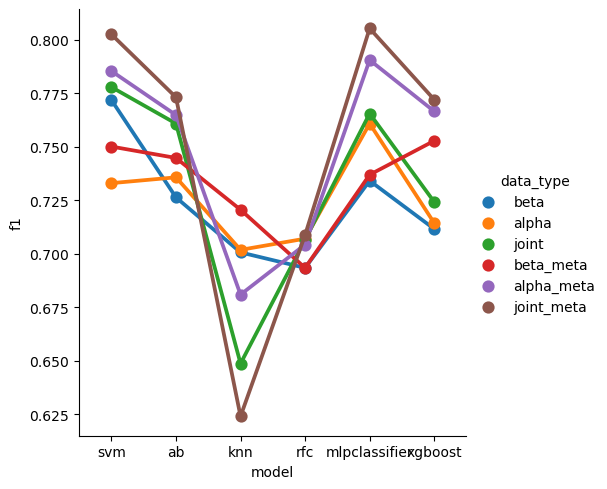

In [19]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

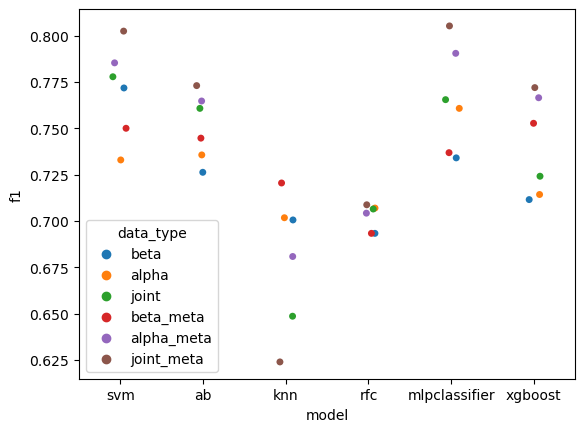

In [20]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [21]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model', SVC(C=50, probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                      n_estimators=200, random_state=42))]),
  'knn': Pipeline(steps=[('model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=3, min_samples_leaf=8,
                                          n_estimators=75, n_jobs=-1,
                                          random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50, 25, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('model',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_b

# Making metrics dataframe

In [22]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['svm']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [23]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [24]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,svm,0.771739,0.669811,0.910256
1,alpha,mlpclassifier,0.732919,0.710843,0.756410
2,joint,svm,0.777778,0.750000,0.807692
3,beta_meta,xgboost,0.750000,0.614754,0.961538
4,alpha_meta,mlpclassifier,0.785276,0.752941,0.820513
5,joint_meta,svm,0.802395,0.752809,0.858974


In [25]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [26]:
beta_predictions = all_clfs['beta'][0]['svm'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['svm'].predict_proba(X_test_data['alpha'])[::,1]
beta_meta_predictions = all_clfs['beta_meta'][0]['svm'].predict_proba(X_test_data['beta_meta'])[::,1]
alpha_meta_predictions = all_clfs['alpha_meta'][0]['svm'].predict_proba(X_test_data['alpha_meta'])[::,1]
joint_predictions = all_clfs['joint'][0]['svm'].predict_proba(X_test_data['joint'])[::,1]
joint_meta_predictions = all_clfs['joint_meta'][0]['svm'].predict_proba(X_test_data['joint_meta'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'beta_meta_proba': beta_meta_predictions,
    'alpha_meta_proba': alpha_meta_predictions,
    'joint_proba': joint_predictions,
    'joint_meta_proba': joint_meta_predictions,
    'covid': proba_labels
})

In [27]:
probability_df

,beta_proba,alpha_proba,beta_meta_proba,alpha_meta_proba,joint_proba,joint_meta_proba,covid
637,0.845641,0.964052,0.935953,0.957044,0.992667,0.992682,covid
638,0.826747,0.086477,0.741880,0.119540,0.033983,0.093175,covid
639,0.960358,0.355258,0.880814,0.534977,0.295264,0.437313,covid
640,0.940772,0.541323,0.905337,0.688699,0.753117,0.900286,covid
641,0.610028,0.875007,0.803112,0.893018,0.883912,0.857367,covid
...,...,...,...,...,...,...,...
779,0.309510,0.596516,0.859306,0.349408,0.298258,0.262107,healthy
780,0.859511,0.727776,0.740442,0.843180,0.451792,0.500000,healthy
781,0.703659,0.522383,0.841489,0.232880,0.392778,0.336853,healthy
782,0.130265,0.536873,0.249328,0.853087,0.608532,0.899533,healthy


# One folder out CV

In [28]:
data_joint_meta

,a_cluster_0,a_cluster_1,a_cluster_2,a_cluster_3,a_cluster_4,a_cluster_5,a_cluster_6,a_cluster_7,a_cluster_8,a_cluster_9,...,b_cluster_51,b_cluster_52,b_cluster_53,b_cluster_54,b_cluster_55,b_cluster_56,b_cluster_57,b_cluster_58,b_cluster_59,b_cluster_60
0,-0.698914,-0.712879,-0.707034,-0.579735,-0.474557,-0.177511,-0.010007,-0.677918,2.645309,0.782534,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.134037,-0.216296,-0.502417,-0.310594,-0.340567
1,-0.698914,-0.712879,-0.707034,-0.579735,1.060203,5.281411,1.753486,-0.677918,-0.319670,-0.935883,...,-0.239136,4.946921,6.002299,-0.373045,-0.326356,2.159940,-0.216296,-0.502417,-0.310594,-0.340567
2,-0.698914,-0.710197,-0.707034,-0.579735,-0.272895,-0.177511,0.041841,-0.677918,-0.319670,0.931003,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.594823,-0.216296,-0.502417,-0.310594,-0.340567
3,-0.698914,-0.712879,-0.707034,-0.579735,0.184020,-0.177511,0.785781,-0.659708,-0.319670,0.920116,...,-0.239136,-0.214010,-0.240259,2.624048,-0.326356,1.392589,-0.216296,-0.502417,-0.310594,-0.340567
4,-0.698914,-0.712879,-0.707034,-0.579735,1.385004,-0.177511,-0.538369,-0.677918,-0.319670,0.757735,...,-0.239136,4.826291,-0.240259,-0.373045,-0.326356,1.198760,3.405240,3.292207,-0.310594,-0.340567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,0.903848,0.886656,0.700840,0.887638,0.245173,-0.177511,0.559812,0.672229,-0.319670,-0.101881,...,-0.239136,-0.214010,-0.240259,-0.373045,-0.326356,-0.293409,-0.216296,0.135274,-0.310594,0.454214
1220,0.995912,1.170559,1.441723,0.765930,-0.802055,-0.177511,-0.748075,1.391013,-0.319670,0.114269,...,0.408599,-0.214010,-0.240259,0.118638,0.196466,-0.187271,-0.216296,-0.157519,-0.310594,-0.340567
1221,0.677856,1.024367,1.126835,1.175422,-0.332931,-0.177511,-0.562312,1.164766,-0.319670,0.326711,...,-0.239136,-0.214010,-0.240259,-0.373045,0.388104,0.741828,-0.216296,1.854173,-0.310594,0.834279
1222,0.830438,1.042379,0.891708,0.814846,-1.024502,-0.177511,-0.889254,0.988008,-0.319670,-0.144911,...,0.113195,-0.214010,0.362572,-0.105598,0.242415,-0.461812,-0.216296,0.060397,-0.021277,-0.106747


In [29]:
data_joint_meta['project'] = data_joint_meta.folder

In [54]:
from sklearn.svm import SVC
f1_score(SVC(C=5, probability=True, random_state=42).fit(X_train_data['joint_meta'], 
                                                         y_train_data['joint_meta']).predict(X_test_data['joint_meta']),
         y_test_data['joint_meta'])

0.8023952095808383

In [30]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint_m[0]['svm'], 
                                 data_joint_meta.drop(columns=['folder', 'is_test_run']), 
                                 [x for x in data_joint_meta.project.unique()], 
                                 y_column='covid', 
                                 batch_column='project', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 ))

In [31]:
def make_score_column(df):
    df['score'] = df[df.columns[1]]
    df['metrics'] = df.columns[1]
    df = df.drop(columns=[df.columns[1]])
    return df

In [32]:
metrics_df[0]

,folder,f1
0,#2,0.951923
1,#3,0.959276
2,#1,0.929461
3,#9,0.917647
4,#5,0.762590
5,#6,0.802395
6,#7,0.854015
7,#8,0.944444


In [33]:
metrics_df = pd.concat([make_score_column(metrics_df[i]) for i in range(3)])
metrics_df

,folder,score,metrics
0,#2,0.951923,f1
1,#3,0.959276,f1
2,#1,0.929461,f1
3,#9,0.917647,f1
4,#5,0.762590,f1
5,#6,0.802395,f1
6,#7,0.854015,f1
7,#8,0.944444,f1
0,#2,0.942857,precision
1,#3,0.972477,precision


In [34]:
metrics_df.folder = metrics_df.folder.apply(lambda x: x.replace('_DNA', '').split('/')[-1].split('_')[-1])

<AxesSubplot:xlabel='metrics', ylabel='score'>

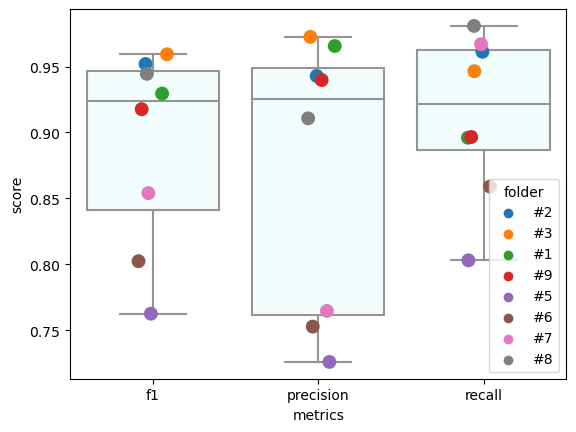

In [35]:
sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure')

# Feature importances analysis

In [36]:
data = {'feature_names': X_train_data['joint_meta'].columns}
for mdl in ['ab', 'xgboost', 'rfc']:
    data[mdl] = best_clfs_joint_m[0][mdl]['model'].feature_importances_
fi_df = pd.DataFrame(data)

# Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['xgboost'], ascending=False, inplace=True)
fi_df = fi_df.head(40)
fi_df = fi_df.reset_index(drop=True)

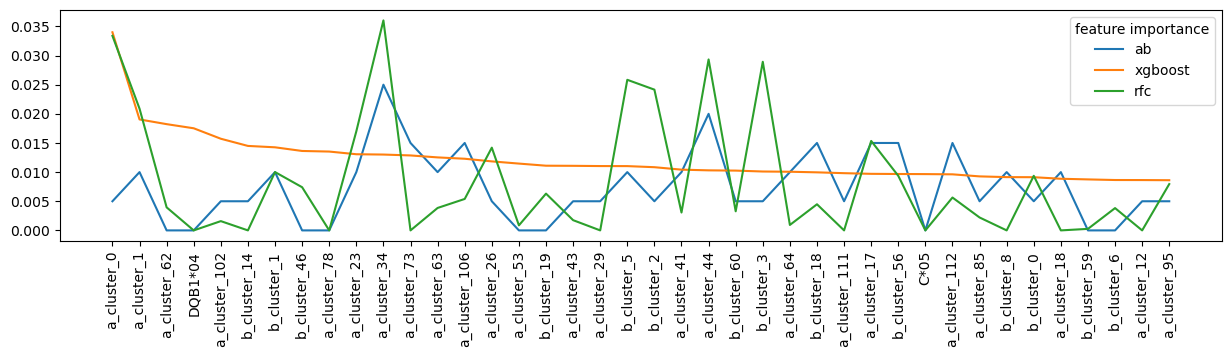

In [37]:
fig, ax = plt.subplots(figsize=(15, 3))
for mdl in ['ab', 'xgboost', 'rfc']:
    ax.plot(fi_df.index, fi_df[mdl], label=mdl)
ax.set_xticks(ticks=range(len(fi_df.index)),
              labels=fi_df.feature_names,
              rotation=90)
ax.legend(title='feature importance')

# Plotting

In [38]:
for key in all_clfs:
    all_clfs[key][0][all_clfs[key][2]].fit(X_train_data[key], y_train_data[key])

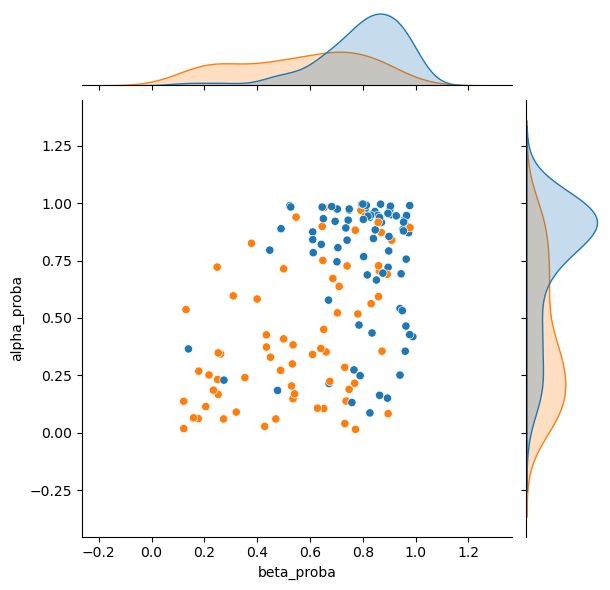

In [39]:
sns.jointplot(data=probability_df, x='beta_proba', y='alpha_proba', hue='covid', legend=False)


In [40]:
all_clfs['beta'][0]['svm']

Pipeline(steps=[('model', SVC(C=5, probability=True, random_state=42))])

In [41]:
from scipy import stats
def scatter_hist(x, y, ax, ax_histx, ax_histy, label='healthy'):

    # the scatter plot:
    ax.scatter(x, y, label=label)
    sns.histplot(x=x, kde=True, alpha=0.5, ax=ax_histx)
    sns.histplot(y=y, kde=True, alpha=0.5, ax=ax_histy)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.set(xlabel=None)  # remove the axis label
    ax_histx.set(ylabel=None)  # remove the axis label
    ax_histy.set(xlabel=None)  # remove the axis label
    ax_histy.set(ylabel=None)  # remove the axis label
    ax_histy.axis('off')
    ax_histx.axis('off')    

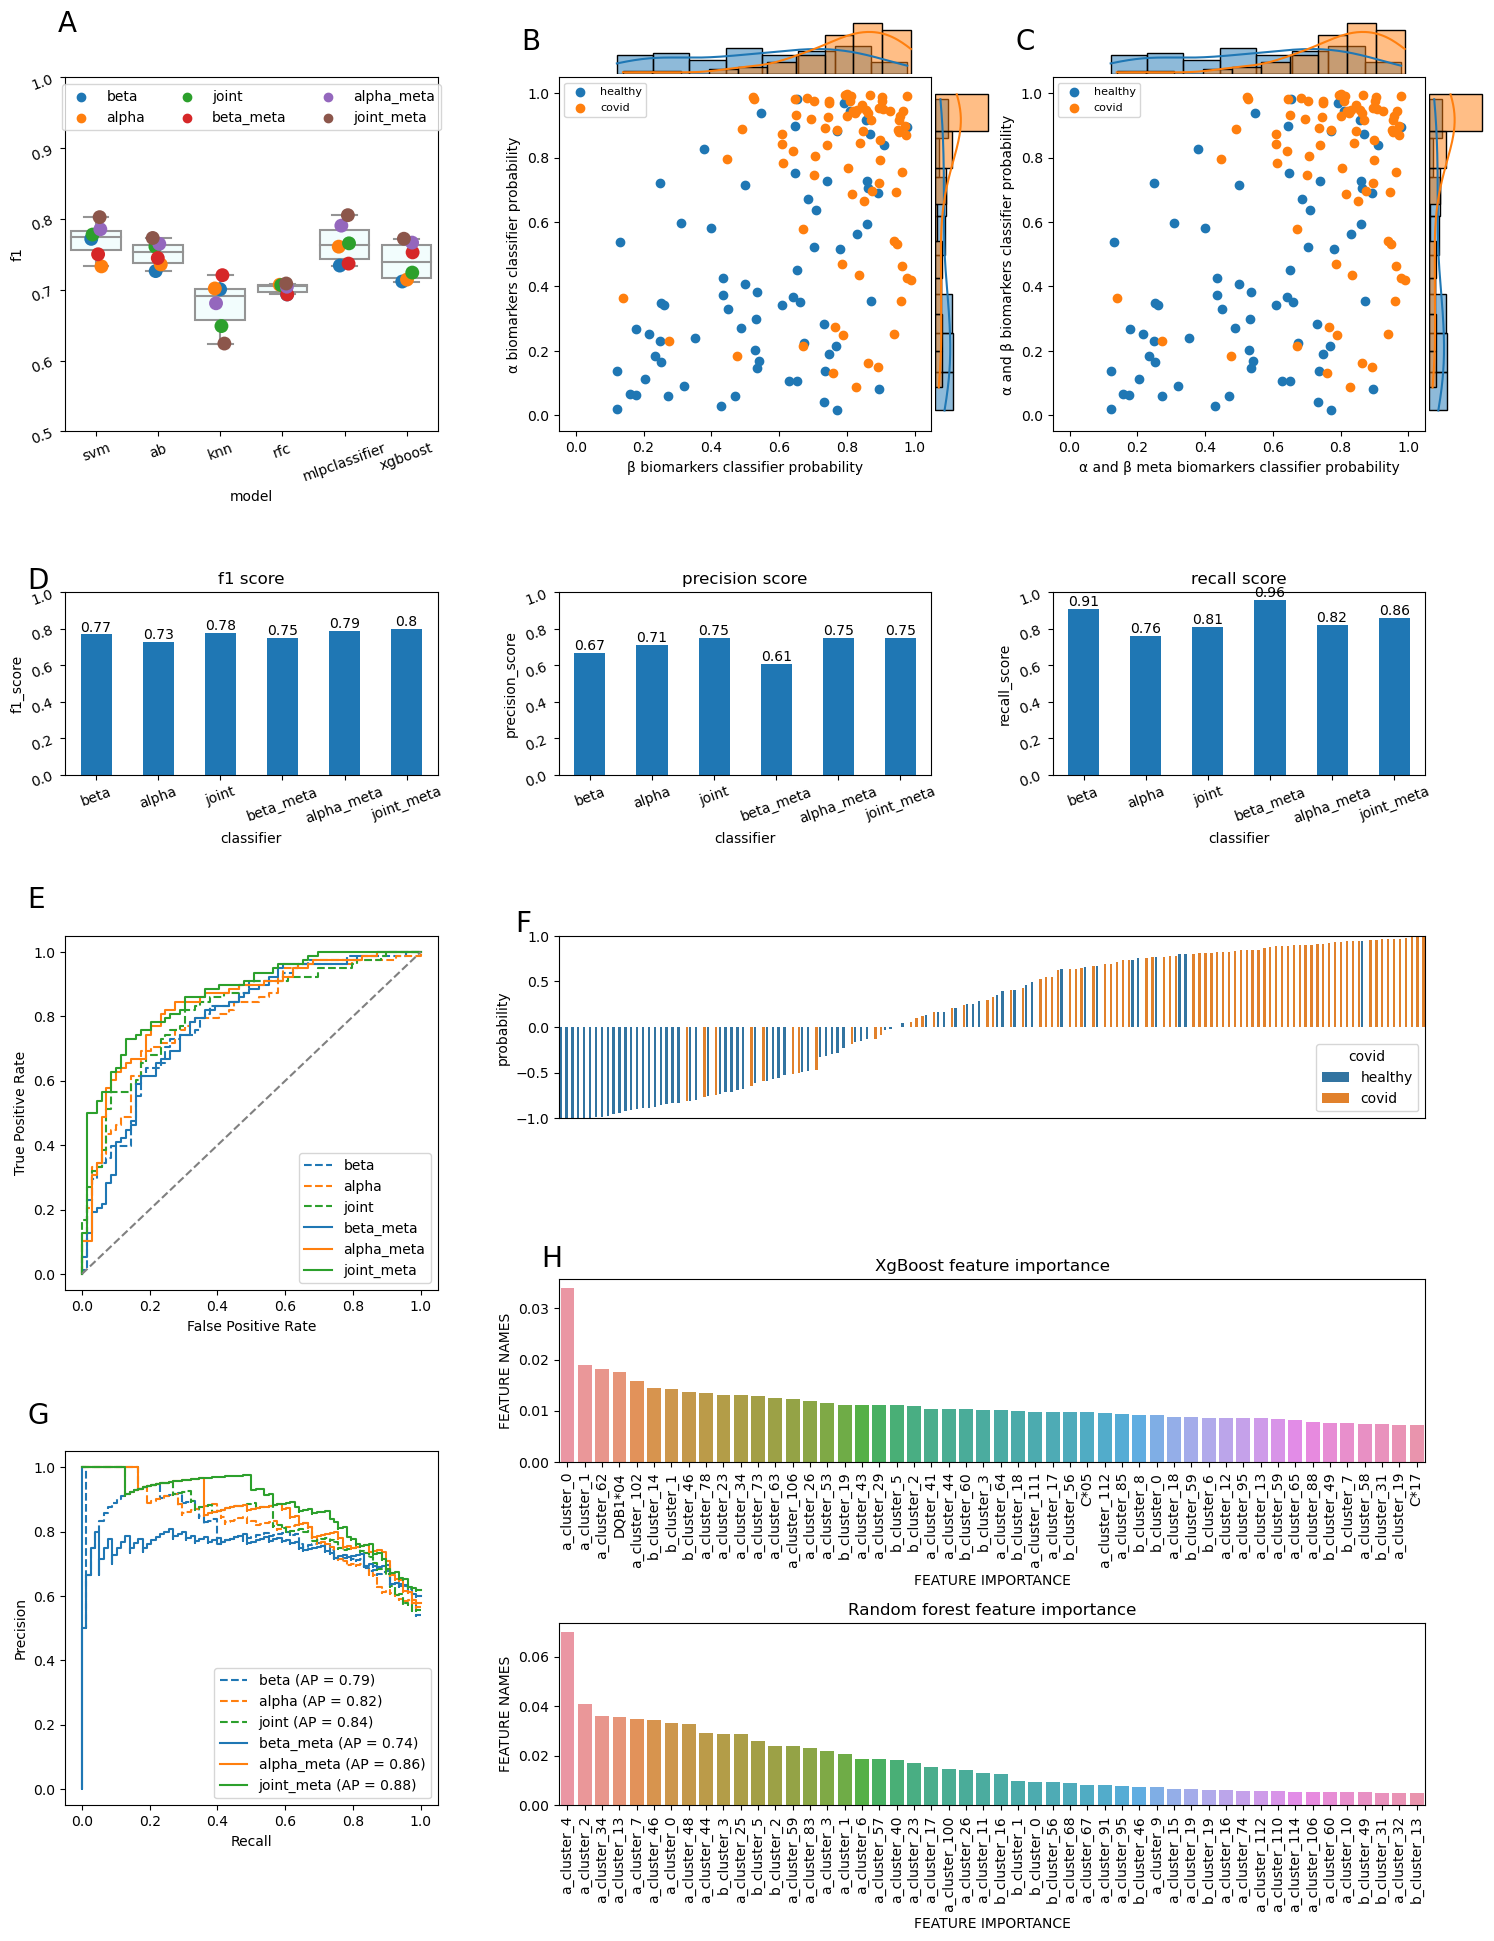

In [46]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=12, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14

colors = {'beta': '#1f77b4', 'alpha': '#ff7f0e', 'joint': '#2ca02c'}
########################################################

for i, (letter, metrics) in enumerate(zip(['D', None, None], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[3:5, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f"{metrics.replace('_', ' ')}")
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    if letter is not None:
        ax.text(delta_x, delta_y, letter,
             horizontalalignment='left',
             verticalalignment='top',
            transform=ax.transAxes,
                size=font_size)

########################################################
ax3 = fig.add_subplot(gs[5:8, 0])

for key in all_clfs:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    ax3.plot(fpr,tpr, label=key, linestyle='solid' if 'meta' in key else 'dashed',
             color=colors[key.split('_')[0]])

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
# ax3.set_title('ROC-curve')
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################
ax11 = fig.add_subplot(gs[8:11, 0])

for key in all_clfs:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key][0]['svm'], X_test_data[key], y_test_data[key], name=key, ax=ax11, 
        linestyle='solid' if 'meta' in key else 'dashed', color=colors[key.split('_')[0]]
    )

ax11.set_ylabel('Precision')
ax11.set_xlabel('Recall')
ax11.legend()
# ax3.set_title('ROC-curve')
ax11.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax11.transAxes,
        size=font_size)

########################################################

ax4 = fig.add_subplot(gs[:3, 1])
ax_histx = ax4.inset_axes([0, 1.01, 1, 0.15], sharex=ax4)
ax_histy = ax4.inset_axes([1.01, 0, 0.15, 1], sharey=ax4)
scatter_hist(probability_df[probability_df.covid == 'healthy'].beta_proba, probability_df[probability_df.covid == 'healthy'].alpha_proba, ax4, ax_histx, ax_histy, label='healthy')
scatter_hist(probability_df[probability_df.covid == 'covid'].beta_proba, probability_df[probability_df.covid == 'covid'].alpha_proba, ax4, ax_histx, ax_histy, label='covid')
ax4.legend(fontsize="8", loc ="upper left")
ax4.set_ylim(-0.05, 1.05)
ax4.set_xlim(-0.05, 1.05)
# ax4.set_title('Probability of COVID-19+ for α vs β biomarkers')
ax4.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)
ax4.set_xlabel('β biomarkers classifier probability')
ax4.set_ylabel('α biomarkers classifier probability')

########################################################

ax5 = fig.add_subplot(gs[:3, 2])
ax_histx = ax5.inset_axes([0, 1.01, 1, 0.15], sharex=ax4)
ax_histy = ax5.inset_axes([1.01, 0, 0.15, 1], sharey=ax4)
scatter_hist(probability_df[probability_df.covid == 'healthy'].beta_proba, probability_df[probability_df.covid == 'healthy'].alpha_proba, ax5, ax_histx, ax_histy, label='healthy')
scatter_hist(probability_df[probability_df.covid == 'covid'].beta_proba, probability_df[probability_df.covid == 'covid'].alpha_proba, ax5, ax_histx, ax_histy, label='covid')
ax5.legend(fontsize="8", loc ="upper left")
ax5.set_ylim(-0.05, 1.05)
ax5.set_xlim(-0.05, 1.05)
# ax5.set_title('Probability of COVID-19+ for α and β biomarkers vs meta biomarkers')
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_xlabel('α and β meta biomarkers classifier probability')
ax5.set_ylabel('α and β biomarkers classifier probability')


########################################################

ax6 = fig.add_subplot(gs[5:7, 1:])
plot_waterfall_by_column(probability_df, proba_column='joint_meta_proba', label_column='covid', ax=ax6)
# ax6.set_title('Waterfall plot for α+β metaclone classifier')
ax6.text(delta_x+0.05, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.tick_params(bottom=False)
ax6.set_ylim(-1, 1)

########################################################
# ax7 = fig.add_subplot(gs[5:7, 2])

# sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10, ax=ax7)
# sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure', ax=ax7)
# # ax7.set_title('Scores across batches for α+β metaclone classifier')
# ax7.set_ylim(0.5, 1.1)
# ax7.text(delta_x, delta_y, 'G',
#      horizontalalignment='left',
#      verticalalignment='top',
#     transform=ax7.transAxes,
#         size=font_size)
########################################################

ax8 = fig.add_subplot(gs[7:9, 1:])
plot_feature_importances(best_clfs_joint_m[0]['xgboost']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='xgboost', 
                         k_best=50,
                         ax=ax8)
# for mdl in ['ab', 'xgboost', 'rfc']:
#     ax8.plot(fi_df.index, fi_df[mdl], label=mdl)
# ax8.set_xticks(ticks=range(len(fi_df.index)),
#               labels=fi_df.feature_names,
#               rotation=90)
ax8.text(delta_x+0.08, delta_y+0.05, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax8.transAxes,
        size=font_size)
ax8.set_title('XgBoost feature importance')
########################################################

ax10 = fig.add_subplot(gs[9:11, 1:])
plot_feature_importances(best_clfs_joint_m[0]['rfc']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='rfc', 
                         k_best=50,
                         ax=ax10)
ax10.set_title('Random forest feature importance')

########################################################

ax9 = fig.add_subplot(gs[:3, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9, s=10)
sns.boxplot(data=comparison_df, x="model", y="f1", ax=ax9, color='azure')
ax9.text(delta_x+0.08, delta_y+0.05, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0.5, 1)
ax9.legend(ncol=3,  loc='upper center')

########################################################

plt.tight_layout()
plt.savefig("figures/fig4.svg")
plt.savefig("figures/fig4.pdf")
plt.savefig("figures/fig4.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A. Distribution of f1-score for all the evaluated models and different types of feature sets.

B. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

C. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

D. Distribution of target metrics (f1-score, precision, recall for all the evaluated models.

E. ROC-curve plot for all the evaluated models.

F. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

G. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

H. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.

# Supplementary Figure 7

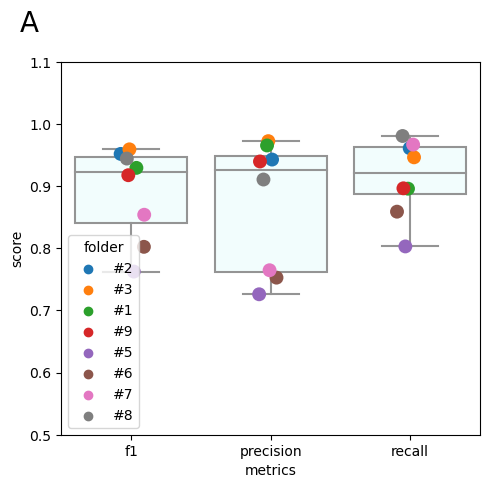

In [49]:
fig = plt.figure(figsize=(5, 5))
gs = GridSpec(nrows=1, 
              ncols=1)
font_size=20
delta_x=-0.1
delta_y=1.14

ax7 = fig.add_subplot(gs[0, 0])

sns.stripplot(data=metrics_df, x="metrics", y="score", hue="folder", s=10, ax=ax7)
sns.boxplot(data=metrics_df, x="metrics", y="score", color='azure', ax=ax7)
# ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0.5, 1.1)
ax7.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)


plt.tight_layout()
plt.savefig("figures/supp_fig7.svg")
plt.savefig("figures/supp_fig7.pdf")
plt.savefig("figures/supp_fig7.png")
plt.show()